In [1]:
!pip install pmdarima

  Using cached Cython-3.0.10-py2.py3-none-any.whl.metadata (3.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.8 MB/s eta 0:00:00a 0:00:01
Using cached Cython-3.0.10-py2.py3-none-any.whl (1.2 MB)


In [19]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [21]:
import numpy as np
import pandas as pd
import pmdarima
import statsmodels
import sklearn

print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("pmdarima version:", pmdarima.__version__)
print("Statsmodels version:", statsmodels.__version__)
print("Scikit-learn version:", sklearn.__version__)

from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from itertools import permutations
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
from tabulate import tabulate


Numpy version: 1.26.4
Pandas version: 2.2.2
pmdarima version: 2.0.4
Statsmodels version: 0.14.2
Scikit-learn version: 1.4.2


In [9]:
# Define the path to the Excel file
file_path = '/Users/akshay/Downloads/HBS Table No. 218 _ Daily Exchange Rate of the Indian Rupee.xlsx'

# Load the Excel file, specifying that header is in the 6th row and skipping the 7th row
data = pd.read_excel(file_path, header=5, skiprows=[6])

# Remove the first column if it contains empty values
data = data.drop(columns=[data.columns[0]])

# Convert 'Date' column to datetime and filter by year
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data[(data['Date'].dt.year >= 2010) & (data['Date'].dt.year <= 2023)]

# Convert currency columns to numeric values
currency_columns = ['US Dollar', 'Pound Sterling', 'Euro', 'Japanese Yen']
for col in currency_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Aggregate Daily Data into Weekly Averages
data.set_index('Date', inplace=True)
weekly_data = data.resample('W').mean()

# Export the Weekly Dataset to a New Excel File
output_file_path = '/Users/akshay/Downloads/weekly_exchange_rates.xlsx'
weekly_data.to_excel(output_file_path)

print(f"Weekly dataset created successfully and saved to {output_file_path}.")


Weekly dataset created successfully and saved to /Users/akshay/Downloads/weekly_exchange_rates.xlsx.


In [10]:
# Load the Excel file, specifying that header is in the 6th row and skipping the 7th row
# Note: Python uses 0-based indexing, so header=5 corresponds to the 6th row
data = pd.read_excel(file_path, header=5, skiprows=[6])

# Note : remove columns A as it contains empty value
data = data.drop(columns=[data.columns[0]])

# Filtering the data based on dates and converting to weekly averages

# For example, filtering data from 2010 to 2023 and converting to datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # Convert 'Date' column to datetime
data = data[(data['Date'].dt.year >= 2010) & (data['Date'].dt.year <= 2023)]  # Filter by year

# Display the first few rows of the DataFrame
print(data.head())

# Display the last few rows of the DataFrame
print(data.tail())

# Get a summary of the DataFrame
data.info()


         Date US Dollar Pound Sterling     Euro Japanese Yen
10 2023-12-29   83.1164       106.1053  92.0049        58.82
11 2023-12-28   83.2254        106.609  92.4523        58.94
12 2023-12-27   83.3226       106.0891  92.0154        58.41
13 2023-12-26   83.1703        105.669  91.6836        58.45
14 2023-12-22   83.2493       105.6223  91.5559        58.49
           Date US Dollar Pound Sterling   Euro Japanese Yen
3383 2010-01-07     45.87        73.2636  65.94        49.76
3384 2010-01-06     46.12        73.7182   66.2        50.14
3385 2010-01-05      46.2        74.5298  66.78        50.35
3386 2010-01-04     46.51        74.8532  66.48        50.07
3387 2010-01-01     46.65        75.2465  66.83        50.11
<class 'pandas.core.frame.DataFrame'>
Index: 3378 entries, 10 to 3387
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            3378 non-null   datetime64[ns]
 1   US Do

In [11]:
# The exchange rates are given as INR per unit of foreign currency
# We'll invert these rates to represent the amount of foreign currency per INR for direct comparison
# Convert columns to numeric, coercing errors to NaN
data['US Dollar'] = pd.to_numeric(data['US Dollar'], errors='coerce')
data['Pound Sterling'] = pd.to_numeric(data['Pound Sterling'], errors='coerce')
data['Euro'] = pd.to_numeric(data['Euro'], errors='coerce')
data['Japanese Yen'] = pd.to_numeric(data['Japanese Yen'], errors='coerce')

# Now apply the lambda function to invert the rates
data['USD/INR'] = data['US Dollar'].apply(lambda x: 1/x if x else None)
data['GBP/INR'] = data['Pound Sterling'].apply(lambda x: 1/x if x else None)
data['EUR/INR'] = data['Euro'].apply(lambda x: 1/x if x else None)
# Adjusting for 100 JPY to get the rate per INR
data['JPY/INR'] = data['Japanese Yen'].apply(lambda x: 1/(x/100) if x else None)
# Display the first few rows of the transformed DataFrame
print(data[['Date', 'USD/INR', 'GBP/INR', 'EUR/INR', 'JPY/INR']].head())

# Display the last few rows of the transformed DataFrame
print(data[['Date', 'USD/INR', 'GBP/INR', 'EUR/INR', 'JPY/INR']].tail())

# Summary statistics of the transformed rates
print(data[['USD/INR', 'GBP/INR', 'EUR/INR', 'JPY/INR']].describe())


         Date   USD/INR   GBP/INR   EUR/INR   JPY/INR
10 2023-12-29  0.012031  0.009425  0.010869  1.700102
11 2023-12-28  0.012016  0.009380  0.010816  1.696641
12 2023-12-27  0.012002  0.009426  0.010868  1.712036
13 2023-12-26  0.012024  0.009464  0.010907  1.710864
14 2023-12-22  0.012012  0.009468  0.010922  1.709694
           Date   USD/INR   GBP/INR   EUR/INR   JPY/INR
3383 2010-01-07  0.021801  0.013649  0.015165  2.009646
3384 2010-01-06  0.021683  0.013565  0.015106  1.994416
3385 2010-01-05  0.021645  0.013417  0.014975  1.986097
3386 2010-01-04  0.021501  0.013359  0.015042  1.997204
3387 2010-01-01  0.021436  0.013290  0.014963  1.995610
           USD/INR      GBP/INR      EUR/INR      JPY/INR
count  3375.000000  3375.000000  3375.000000  3375.000000
mean      0.015885     0.011148     0.013192     1.659064
std       0.002970     0.001346     0.001564     0.154306
min       0.011991     0.009290     0.010816     1.386578
25%       0.013643     0.010043     0.011908     1

In [13]:
def load_and_prepare_data(file_path):
    data = pd.read_excel(file_path, header=5, skiprows=[6])
    data = data.drop(columns=[data.columns[0]])
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data = data[(data['Date'].dt.year >= 2010) & (data['Date'].dt.year <= 2023)]

    rate_columns = ['US Dollar', 'Pound Sterling', 'Euro', 'Japanese Yen']
    for col in rate_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[f'{col}/INR'] = data[col].apply(lambda x: 1/x if x else None)  # Convert INR per currency to currency per INR

    # Ensure data is sorted by date to correctly align 'Today' and 'Tomorrow'
    data = data.sort_values(by='Date')
    return data

def find_2_way_arbitrage_day_to_day(data, initial_inr=100, profit_threshold=0.001):
    currencies = ['US Dollar/INR', 'Pound Sterling/INR', 'Euro/INR', 'Japanese Yen/INR']
    opportunities = {'Date Today': [], 'Date Tomorrow': []}
    for currency in currencies:
        opportunities[f'{currency} Profit'] = []
        opportunities[f'{currency} Profit Percentage'] = []
        opportunities[f'{currency} Rate Today'] = []
        opportunities[f'{currency} Rate Tomorrow'] = []

    for i in range(len(data) - 1):
        row_today = data.iloc[i]
        row_tomorrow = data.iloc[i + 1]
        opportunities['Date Today'].append(row_today['Date'])
        opportunities['Date Tomorrow'].append(row_tomorrow['Date'])
        for currency in currencies:
            rate_today = row_today[currency]
            rate_tomorrow = row_tomorrow[currency]
            opportunities[f'{currency} Rate Today'].append(rate_today)
            opportunities[f'{currency} Rate Tomorrow'].append(rate_tomorrow)
            if pd.isnull(rate_today) or pd.isnull(rate_tomorrow) or rate_today == 0 or rate_tomorrow == 0:
                profit_or_loss = None
                profit_percentage = None
            else:
                rate_today_inr_to_foreign = rate_today
                rate_tomorrow_foreign_to_inr = 1 / rate_tomorrow
                final_inr_after_arbitrage = initial_inr * rate_today_inr_to_foreign * rate_tomorrow_foreign_to_inr
                profit_or_loss = final_inr_after_arbitrage - initial_inr
                profit_percentage = (profit_or_loss / initial_inr) * 100
                if profit_or_loss <= profit_threshold:
                    profit_or_loss = None
                    profit_percentage = None
            print(f"2-way arbitrage Profit for {currency} at Today's date {row_today['Date']} is {profit_or_loss}")
            opportunities[f'{currency} Profit'].append(profit_or_loss)
            opportunities[f'{currency} Profit Percentage'].append(profit_percentage)

    return pd.DataFrame(opportunities)

# Main execution should proceed with loading the data and finding arbitrage opportunities
file_path = '/Users/akshay/Downloads/HBS Table No. 218 _ Daily Exchange Rate of the Indian Rupee.xlsx'
prepared_data = load_and_prepare_data(file_path)

if not prepared_data.empty:
    arbitrage_opportunities_df = find_2_way_arbitrage_day_to_day(prepared_data)
    if not arbitrage_opportunities_df.empty:
        output_file_path = '/Users/akshay/Downloads/2_way_arbitrage_opportunities.xlsx'
        arbitrage_opportunities_df.to_excel(output_file_path, index=False)
        print(f"Arbitrage opportunities saved to Excel at {output_file_path}.")
    else:
        print("No significant arbitrage opportunities found.")
else:
    print("Data loading or preparation failed.")


2-way arbitrage Profit for US Dollar/INR at Today's date 2010-01-01 00:00:00 is None
2-way arbitrage Profit for Pound Sterling/INR at Today's date 2010-01-01 00:00:00 is None
2-way arbitrage Profit for Euro/INR at Today's date 2010-01-01 00:00:00 is None
2-way arbitrage Profit for Japanese Yen/INR at Today's date 2010-01-01 00:00:00 is None
2-way arbitrage Profit for US Dollar/INR at Today's date 2010-01-04 00:00:00 is None
2-way arbitrage Profit for Pound Sterling/INR at Today's date 2010-01-04 00:00:00 is None
2-way arbitrage Profit for Euro/INR at Today's date 2010-01-04 00:00:00 is 0.4512635379061436
2-way arbitrage Profit for Japanese Yen/INR at Today's date 2010-01-04 00:00:00 is 0.5592170960654954
2-way arbitrage Profit for US Dollar/INR at Today's date 2010-01-05 00:00:00 is None
2-way arbitrage Profit for Pound Sterling/INR at Today's date 2010-01-05 00:00:00 is None
2-way arbitrage Profit for Euro/INR at Today's date 2010-01-05 00:00:00 is None
2-way arbitrage Profit for Japa

/var/folders/ts/sqvxkby101b3x__cvt7j6vdr0000gn/T/ipykernel_2898/1790672960.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # First forward fill
/var/folders/ts/sqvxkby101b3x__cvt7j6vdr0000gn/T/ipykernel_2898/1790672960.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)  # Then backward fill if needed
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

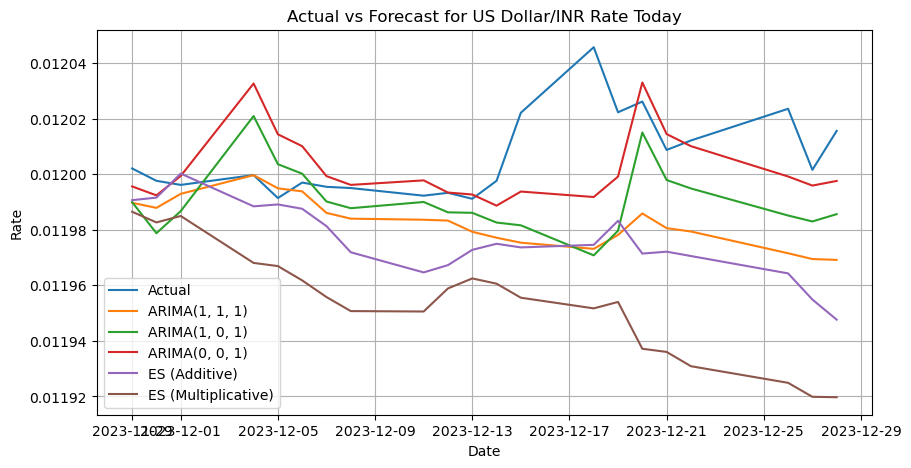

ARIMA(1, 1, 1) RMSE: 3.086213847225222e-05
ARIMA(1, 0, 1) RMSE: 2.5739140061336483e-05
ARIMA(0, 0, 1) RMSE: 1.86105915713206e-05
ES (Additive) RMSE: 3.698596378009605e-05
ES (Multiplicative) RMSE: 5.9916291922054564e-05


/var/folders/ts/sqvxkby101b3x__cvt7j6vdr0000gn/T/ipykernel_2898/1790672960.py:68: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Ma

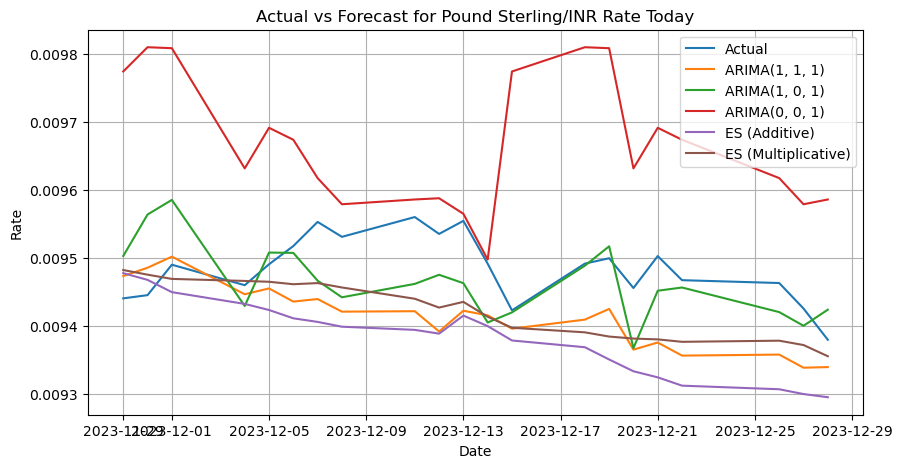

ARIMA(1, 1, 1) RMSE: 8.969777044965204e-05
ARIMA(1, 0, 1) RMSE: 6.479225944191501e-05
ARIMA(0, 0, 1) RMSE: 0.00021482383654067427
ES (Additive) RMSE: 0.00011823164109244848
ES (Multiplicative) RMSE: 7.885574799202611e-05


/var/folders/ts/sqvxkby101b3x__cvt7j6vdr0000gn/T/ipykernel_2898/1790672960.py:68: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index

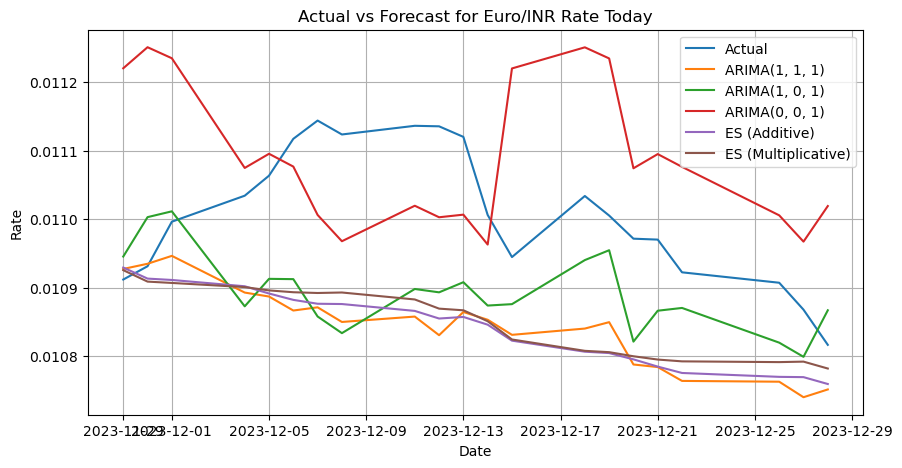

ARIMA(1, 1, 1) RMSE: 0.00018709305822479182
ARIMA(1, 0, 1) RMSE: 0.0001555976744810781
ARIMA(0, 0, 1) RMSE: 0.00017377888121914665
ES (Additive) RMSE: 0.00018459140109032042
ES (Multiplicative) RMSE: 0.0001756048282050068


/var/folders/ts/sqvxkby101b3x__cvt7j6vdr0000gn/T/ipykernel_2898/1790672960.py:68: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Ma

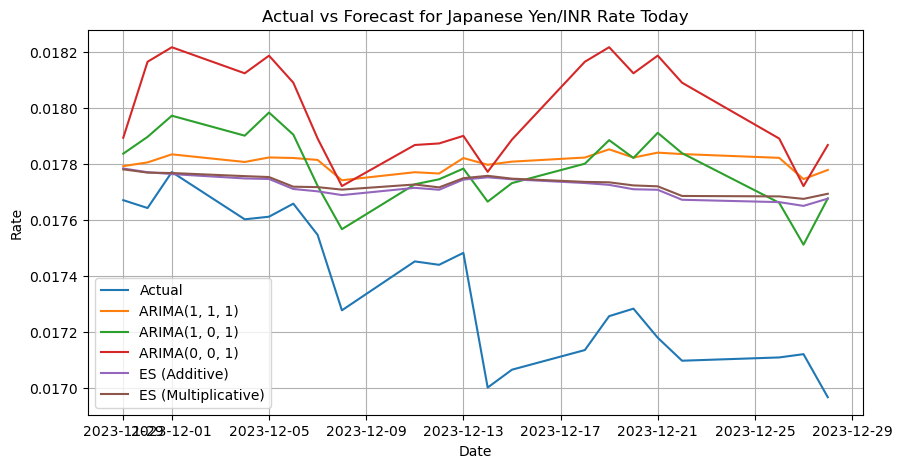

ARIMA(1, 1, 1) RMSE: 0.0005175423702360594
ARIMA(1, 0, 1) RMSE: 0.00048137437058254633
ARIMA(0, 0, 1) RMSE: 0.0006875170556116271
ES (Additive) RMSE: 0.0004346872423532787
ES (Multiplicative) RMSE: 0.0004444476971267679
+----+-------------------------------+-----------------+---------------+-----------------+-------------------------+-------------------------+--------------------------+------------------+----------------+------------------+---------------------------+--------------------------+----------------------------+--------------------------+
|    | Column                        |   ADF Statistic |   ADF p-value | ADF Unit Root   |   ADF Critical Value 1% |   ADF Critical Value 5% |   ADF Critical Value 10% |   KPSS Statistic |   KPSS p-value | KPSS Unit Root   |   KPSS Critical Value 10% |   KPSS Critical Value 5% |   KPSS Critical Value 2.5% |   KPSS Critical Value 1% |
+====+===============================+=================+===============+=================+==================

/var/folders/ts/sqvxkby101b3x__cvt7j6vdr0000gn/T/ipykernel_2898/1790672960.py:68: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")


In [27]:
def load_data(file_path):
    data = pd.read_excel(file_path)
    data['Date Today'] = pd.to_datetime(data['Date Today'])
    data.set_index('Date Today', inplace=True)
    return data

def prepare_data(data, forecast_period=30):
    data.fillna(method='ffill', inplace=True)  # First forward fill
    data.fillna(method='bfill', inplace=True)  # Then backward fill if needed
    cutoff_date = data.index.max() - pd.DateOffset(months=1)
    train = data[data.index <= cutoff_date]
    test = data[data.index > cutoff_date]
    return train, test

def forecast_currency(train, test, rate_column):
    # Explicit check and handle NaN before fitting the model
    if train[rate_column].isna().any():
        train[rate_column].fillna(train[rate_column].mean(), inplace=True)  # Using mean to fill any stubborn NaNs
    if test[rate_column].isna().any():
        test[rate_column].fillna(train[rate_column].mean(), inplace=True)

    forecasts = {}

    # ARIMA models
    try:
        arima_orders = [(1, 1, 1), (1, 0, 1), (0, 0, 1)]
        for order in arima_orders:
            model = SARIMAX(train[rate_column], order=order, seasonal_order=(1, 1, 1, 12)).fit(disp=False)
            forecasts[f'ARIMA{order}'] = model.forecast(len(test))
    except Exception as e:
        print(f"ARIMA model fitting failed for {rate_column}: {e}")
        for order in arima_orders:
            forecasts[f'ARIMA{order}'] = np.full(len(test), np.nan)

    # Exponential Smoothing models
    try:
        es_model_add = ExponentialSmoothing(train[rate_column], trend='add', seasonal='add', seasonal_periods=12).fit()
        es_model_mul = ExponentialSmoothing(train[rate_column], trend='mul', seasonal='mul', seasonal_periods=12).fit()
        forecasts['ES (Additive)'] = es_model_add.forecast(len(test))
        forecasts['ES (Multiplicative)'] = es_model_mul.forecast(len(test))
    except Exception as e:
        print(f"Exponential Smoothing model fitting failed for {rate_column}: {e}")
        forecasts['ES (Additive)'] = np.full(len(test), np.nan)
        forecasts['ES (Multiplicative)'] = np.full(len(test), np.nan)

    return forecasts, test[rate_column]

def calculate_rmse(actual, forecast):
    return np.sqrt(mean_squared_error(actual, forecast))

def display_results(test, actual, forecasts, currency_name):
    plt.figure(figsize=(10, 5))
    plt.plot(test.index, actual, label='Actual')
    for name, forecast in forecasts.items():
        plt.plot(test.index, forecast, label=name)
    plt.title(f'Actual vs Forecast for {currency_name}')
    plt.xlabel('Date')
    plt.ylabel('Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    for name, forecast in forecasts.items():
        print(f"{name} RMSE: {calculate_rmse(actual, forecast)}")

def unit_root_test(series, column_name):
    adf_result = adfuller(series)
    kpss_result = kpss(series, regression='c', nlags="auto")

    adf_unit_root = 'No' if adf_result[1] < 0.05 else 'Yes'
    kpss_unit_root = 'No' if kpss_result[1] < 0.05 else 'Yes'

    return {
        'Column': column_name,
        'ADF Statistic': adf_result[0],
        'ADF p-value': adf_result[1],
        'ADF Unit Root': adf_unit_root,
        'ADF Critical Value 1%': adf_result[4]['1%'],
        'ADF Critical Value 5%': adf_result[4]['5%'],
        'ADF Critical Value 10%': adf_result[4]['10%'],
        'KPSS Statistic': kpss_result[0],
        'KPSS p-value': kpss_result[1],
        'KPSS Unit Root': kpss_unit_root,
        'KPSS Critical Value 10%': kpss_result[3]['10%'],
        'KPSS Critical Value 5%': kpss_result[3]['5%'],
        'KPSS Critical Value 2.5%': kpss_result[3]['2.5%'],
        'KPSS Critical Value 1%': kpss_result[3]['1%']
    }

def main():
    file_path = '/Users/akshay/Downloads/2_way_arbitrage_opportunities.xlsx'
    data = load_data(file_path)
    train, test = prepare_data(data)
    currencies = ['US Dollar', 'Pound Sterling', 'Euro', 'Japanese Yen']
    all_results = []

    for currency in currencies:
        rate_column = f'{currency}/INR Rate Today'
        forecasts, actual = forecast_currency(train, test, rate_column)
        display_results(test, actual, forecasts, rate_column)

        # Perform unit root test
        unit_root_results = unit_root_test(train[rate_column], rate_column)
        all_results.append(unit_root_results)

    # Create DataFrame for results
    results_df = pd.DataFrame(all_results)

    # Save the DataFrame to an Excel file
    results_df.to_excel('/Users/akshay/Downloads/2_way_unit_root_test_results.xlsx', index=False)

    # Print results with tabulate
    print(tabulate(results_df, headers='keys', tablefmt='grid'))

if __name__ == "__main__":
    main()


In [25]:
def load_and_prepare_data(file_path):
    data = pd.read_excel(file_path, header=5, skiprows=[6])
    data = data.drop(columns=[data.columns[0]])
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data = data[(data['Date'].dt.year >= 2010) & (data['Date'].dt.year <= 2023)]

    rate_columns = ['US Dollar', 'Pound Sterling', 'Euro', 'Japanese Yen']
    for col in rate_columns:
        # Convert rates from INR to each currency
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[f'{col}/INR'] = 1 / data[col]  # Inverse for INR to Currency

    data = data.sort_values(by='Date')
    return data

def find_3_way_arbitrage(data, initial_inr=100):
    currencies = ['US Dollar', 'Pound Sterling', 'Euro', 'Japanese Yen']
    currency_pairs = list(permutations(currencies, 3))
    opportunities = []

    for i in range(len(data) - 1):
        row_today = data.iloc[i]
        row_tomorrow = data.iloc[i + 1]

        for pair in currency_pairs:
            rate1_today = row_today[f'{pair[0]}/INR']
            rate2_today = row_today[f'{pair[1]}/INR']
            rate3_today = row_today[f'{pair[2]}/INR']

            rate2_tomorrow = row_tomorrow[f'{pair[1]}/INR']
            rate3_tomorrow = row_tomorrow[f'{pair[2]}/INR']

            # Calculate cross rates for intra-day
            cross_rate1_2_today = rate2_today / rate1_today
            cross_rate2_3_today = rate3_today / rate2_today
            cross_rate3_1_today = rate1_today / rate3_today

            # Calculate cross rates for inter-day
            cross_rate2_3_tomorrow = rate3_tomorrow / rate2_tomorrow
            cross_rate3_1_tomorrow = rate1_today / rate3_tomorrow

            # Calculate final amounts for intra-day and inter-day
            final_amount_today = initial_inr * cross_rate1_2_today * cross_rate2_3_today * cross_rate3_1_today
            final_amount_tomorrow = initial_inr * cross_rate1_2_today * cross_rate2_3_tomorrow * cross_rate3_1_tomorrow

            profit_today = final_amount_today - initial_inr
            profit_percentage_today = (profit_today / initial_inr) * 100

            profit_tomorrow = final_amount_tomorrow - initial_inr
            profit_percentage_tomorrow = (profit_tomorrow / initial_inr) * 100


            if profit_today > 0:
                print(f"3-way Arbitrage for {pair[0]} -> {pair[1]} -> {pair[2]} at {row_today['Date']} is {profit_today}")
                opportunities.append({
                    'Date': row_today['Date'],
                    'Currencies': f"{pair[0]} -> {pair[1]} -> {pair[2]}",
                    'Profit': profit_today,
                    'Profit Percentage': profit_percentage_today,
                    'Type': 'Intra-day'
                })

            if profit_tomorrow > 0:
                print(f"3-way Arbitrage for {pair[0]} -> {pair[1]} -> {pair[2]} at {row_tomorrow['Date']} is {profit_tomorrow}")
                opportunities.append({
                    'Date': row_tomorrow['Date'],
                    'Currencies': f"{pair[0]} -> {pair[1]} -> {pair[2]}",
                    'Profit': profit_tomorrow,
                    'Profit Percentage': profit_percentage_tomorrow,
                    'Type': 'Inter-day'
                })

    return pd.DataFrame(opportunities)

# Assuming data loading and function calls are handled as before
file_path = '/Users/akshay/Downloads/HBS Table No. 218 _ Daily Exchange Rate of the Indian Rupee.xlsx'
prepared_data = load_and_prepare_data(file_path)
if not prepared_data.empty:
    arbitrage_opportunities_df = find_3_way_arbitrage(prepared_data)
    if not arbitrage_opportunities_df.empty:
        output_file_path = '/Users/akshay/Downloads/3_way_arbitrage_opportunities.xlsx'
        arbitrage_opportunities_df.to_excel(output_file_path, index=False)
        print(f"Arbitrage opportunities saved to Excel at {output_file_path}.")
    else:
        print("No significant arbitrage opportunities found.")
else:
    print("Data loading or preparation failed.")


3-way Arbitrage for Euro -> Pound Sterling -> Japanese Yen at 2010-01-01 00:00:00 is 2.842170943040401e-14
3-way Arbitrage for Japanese Yen -> Euro -> Pound Sterling at 2010-01-01 00:00:00 is 1.4210854715202004e-14
3-way Arbitrage for US Dollar -> Euro -> Pound Sterling at 2010-01-04 00:00:00 is 1.4210854715202004e-14
3-way Arbitrage for US Dollar -> Euro -> Pound Sterling at 2010-01-05 00:00:00 is 0.4512635379061578
3-way Arbitrage for US Dollar -> Euro -> Japanese Yen at 2010-01-04 00:00:00 is 1.4210854715202004e-14
3-way Arbitrage for US Dollar -> Euro -> Japanese Yen at 2010-01-05 00:00:00 is 0.4512635379061436
3-way Arbitrage for US Dollar -> Japanese Yen -> Pound Sterling at 2010-01-04 00:00:00 is 1.4210854715202004e-14
3-way Arbitrage for US Dollar -> Japanese Yen -> Pound Sterling at 2010-01-05 00:00:00 is 0.5592170960655096
3-way Arbitrage for US Dollar -> Japanese Yen -> Euro at 2010-01-04 00:00:00 is 1.4210854715202004e-14
3-way Arbitrage for US Dollar -> Japanese Yen -> Eur

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Arbitrage opportunities saved to Excel at /Users/akshay/Downloads/3_way_arbitrage_opportunities.xlsx.


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anacond

RMSE for Intra-day:
ARIMA(1,1,1): 4.784136562907125e-15
ARIMA(1,0,1): 3.635277901570686e-15
ARIMA(0,0,1): 1.5224039884726203e-14
ES (Additive): 3.2973749567887043e-15
ES (Multiplicative): 3.2990074432713443e-15

RMSE for Inter-day:
ARIMA(1,1,1): 0.5493286987441689
ARIMA(1,0,1): 0.5360054945318287
ARIMA(0,0,1): 0.6690271571228966
ES (Additive): 0.6258920901969557
ES (Multiplicative): 1.1534123809685937


/var/folders/ts/sqvxkby101b3x__cvt7j6vdr0000gn/T/ipykernel_2898/4293363966.py:70: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")
/var/folders/ts/sqvxkby101b3x__cvt7j6vdr0000gn/T/ipykernel_2898/4293363966.py:70: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")


+----+----------------------+-----------------+---------------+-----------------+-------------------------+-------------------------+--------------------------+------------------+----------------+------------------+---------------------------+--------------------------+----------------------------+--------------------------+
|    | Column               |   ADF Statistic |   ADF p-value | ADF Unit Root   |   ADF Critical Value 1% |   ADF Critical Value 5% |   ADF Critical Value 10% |   KPSS Statistic |   KPSS p-value | KPSS Unit Root   |   KPSS Critical Value 10% |   KPSS Critical Value 5% |   KPSS Critical Value 2.5% |   KPSS Critical Value 1% |
+====+======================+=================+===============+=================+=========================+=========================+==========================+==================+================+==================+===========================+==========================+============================+==========================+
|  0 | Intra-day Tr

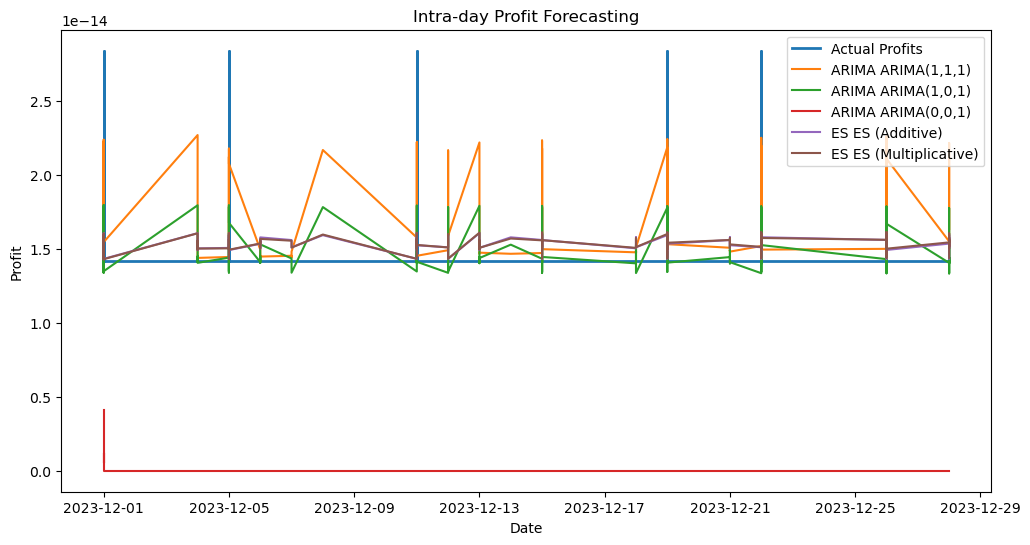

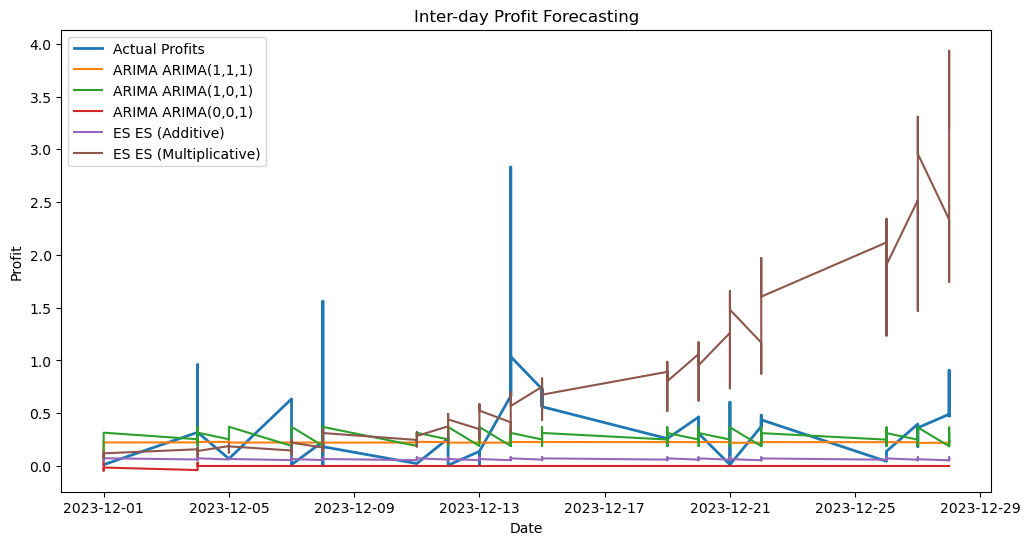

In [25]:
# Load the data
file_path = '/Users/akshay/Downloads/3_way_arbitrage_opportunities.xlsx'
data = pd.read_excel(file_path)
data['Date'] = pd.to_datetime(data['Date'])  # Convert Date to datetime type
data.set_index('Date', inplace=True)  # Set Date as the index

# Split data by type
intra_day_data = data[data['Type'] == 'Intra-day']
inter_day_data = data[data['Type'] == 'Inter-day']

# Function to split data into train and test sets
def split_data(df):
    last_month = df.index.max().replace(day=1)  # Identify the first day of the last month
    train = df[df.index < last_month]
    test = df[df.index >= last_month]
    return train, test

# Splitting intra-day and inter-day data
train_intra, test_intra = split_data(intra_day_data)
train_inter, test_inter = split_data(inter_day_data)

# Function to apply ARIMA and Exponential Smoothing
def forecast_model(train, test, column='Profit'):
    # Fit ARIMA models with different parameters
    arima_models = {
        'ARIMA(1,1,1)': SARIMAX(train[column], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(disp=0),
        'ARIMA(1,0,1)': SARIMAX(train[column], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)).fit(disp=0),
        'ARIMA(0,0,1)': SARIMAX(train[column], order=(0, 0, 1), seasonal_order=(0, 0, 1, 12)).fit(disp=0)
    }
    
    arima_forecasts = {name: model.get_forecast(steps=len(test)).predicted_mean for name, model in arima_models.items()}

    # Fit Exponential Smoothing models
    es_models = {
        'ES (Additive)': ExponentialSmoothing(train[column], trend='add', seasonal='add', seasonal_periods=12).fit(),
        'ES (Multiplicative)': ExponentialSmoothing(train[column], trend='mul', seasonal='mul', seasonal_periods=12).fit()
    }

    es_forecasts = {name: model.forecast(len(test)) for name, model in es_models.items()}

    return arima_forecasts, es_forecasts, test[column]  # Return forecasts and actuals

# Forecasting on intra-day and inter-day data
arima_forecasts_intra, es_forecasts_intra, actual_intra = forecast_model(train_intra, test_intra)
arima_forecasts_inter, es_forecasts_inter, actual_inter = forecast_model(train_inter, test_inter)

# Function to calculate RMSE
def calculate_rmse(actual, forecast):
    return np.sqrt(mean_squared_error(actual, forecast))

# Calculate RMSE for both intra-day and inter-day
rmse_results_intra = {name: calculate_rmse(actual_intra, forecast) for name, forecast in arima_forecasts_intra.items()}
rmse_results_intra.update({name: calculate_rmse(actual_intra, forecast) for name, forecast in es_forecasts_intra.items()})

rmse_results_inter = {name: calculate_rmse(actual_inter, forecast) for name, forecast in arima_forecasts_inter.items()}
rmse_results_inter.update({name: calculate_rmse(actual_inter, forecast) for name, forecast in es_forecasts_inter.items()})

# Output RMSE results
print("RMSE for Intra-day:")
for name, rmse in rmse_results_intra.items():
    print(f"{name}: {rmse}")

print("\nRMSE for Inter-day:")
for name, rmse in rmse_results_inter.items():
    print(f"{name}: {rmse}")

# ADF and KPSS Test function
def unit_root_test(series, column_name):
    adf_result = adfuller(series)
    kpss_result = kpss(series, regression='c', nlags="auto")
    
    adf_unit_root = 'No' if adf_result[1] < 0.05 else 'Yes'
    kpss_unit_root = 'No' if kpss_result[1] < 0.05 else 'Yes'
    
    return {
        'Column': column_name,
        'ADF Statistic': adf_result[0],
        'ADF p-value': adf_result[1],
        'ADF Unit Root': adf_unit_root,
        'ADF Critical Value 1%': adf_result[4]['1%'],
        'ADF Critical Value 5%': adf_result[4]['5%'],
        'ADF Critical Value 10%': adf_result[4]['10%'],
        'KPSS Statistic': kpss_result[0],
        'KPSS p-value': kpss_result[1],
        'KPSS Unit Root': kpss_unit_root,
        'KPSS Critical Value 10%': kpss_result[3]['10%'],
        'KPSS Critical Value 5%': kpss_result[3]['5%'],
        'KPSS Critical Value 2.5%': kpss_result[3]['2.5%'],
        'KPSS Critical Value 1%': kpss_result[3]['1%']
    }

# Perform ADF and KPSS Test on train data
results = [
    unit_root_test(train_intra['Profit'], 'Intra-day Train Data'),
    unit_root_test(train_inter['Profit'], 'Inter-day Train Data')
]

# Create DataFrame for results
results_df = pd.DataFrame(results)

# Save the DataFrame to an Excel file
results_df.to_excel('/Users/akshay/Downloads/3_way_unit_root_test_results.xlsx', index=False)

# Print results with tabulate
print(tabulate(results_df, headers='keys', tablefmt='grid'))

# Plotting the results for intra-day
plt.figure(figsize=(12, 6))
plt.plot(test_intra.index, actual_intra, label='Actual Profits', linewidth=2)
for name, forecast in arima_forecasts_intra.items():
    plt.plot(test_intra.index, forecast, label=f'ARIMA {name}')
for name, forecast in es_forecasts_intra.items():
    plt.plot(test_intra.index, forecast, label=f'ES {name}')
plt.title('Intra-day Profit Forecasting')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.show()

# Plotting the results for inter-day
plt.figure(figsize=(12, 6))
plt.plot(test_inter.index, actual_inter, label='Actual Profits', linewidth=2)
for name, forecast in arima_forecasts_inter.items():
    plt.plot(test_inter.index, forecast, label=f'ARIMA {name}')
for name, forecast in es_forecasts_inter.items():
    plt.plot(test_inter.index, forecast, label=f'ES {name}')
plt.title('Inter-day Profit Forecasting')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.show()


In [ ]:
#Weekly dataset

In [2]:
# Load the weekly dataset
file_path = '/Users/akshay/Downloads/weekly_exchange_rates.xlsx'  # Adjust the file path as necessary
weekly_data = pd.read_excel(file_path)

# Convert the 'Date' column to datetime if it isn't already
if not pd.api.types.is_datetime64_any_dtype(weekly_data['Date']):
    weekly_data['Date'] = pd.to_datetime(weekly_data['Date'])

# Print the DataFrame
print("Weekly Dataset DataFrame:")
print(weekly_data.head())  # Display the first few rows of the DataFrame
print(weekly_data.info())  # Display information about the DataFrame

# Display the entire DataFrame (this might be very large, so use with caution)
# print(weekly_data.to_string())


Weekly Dataset DataFrame:
        Date  US Dollar  Pound Sterling    Euro  Japanese Yen
0 2010-01-03    46.6500       75.246500  66.830       50.1100
1 2010-01-10    46.1000       73.886360  66.192       49.8780
2 2010-01-17    45.5180       73.746040  65.968       49.6620
3 2010-01-24    45.8740       74.766820  65.316       50.4920
4 2010-01-31    46.2875       74.753175  65.010       51.4975
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            731 non-null    datetime64[ns]
 1   US Dollar       730 non-null    float64       
 2   Pound Sterling  730 non-null    float64       
 3   Euro            730 non-null    float64       
 4   Japanese Yen    730 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 28.7 KB
None


In [3]:
# Convert exchange rate columns to numeric, coercing errors to NaN
weekly_data['US Dollar'] = pd.to_numeric(weekly_data['US Dollar'], errors='coerce')
weekly_data['Pound Sterling'] = pd.to_numeric(weekly_data['Pound Sterling'], errors='coerce')
weekly_data['Euro'] = pd.to_numeric(weekly_data['Euro'], errors='coerce')
weekly_data['Japanese Yen'] = pd.to_numeric(weekly_data['Japanese Yen'], errors='coerce')

# Apply the lambda function to invert the rates
weekly_data['USD/INR'] = weekly_data['US Dollar'].apply(lambda x: 1/x if x else None)
weekly_data['GBP/INR'] = weekly_data['Pound Sterling'].apply(lambda x: 1/x if x else None)
weekly_data['EUR/INR'] = weekly_data['Euro'].apply(lambda x: 1/x if x else None)
# Adjusting for 100 JPY to get the rate per INR
weekly_data['JPY/INR'] = weekly_data['Japanese Yen'].apply(lambda x: 1/(x/100) if x else None)

# Display the first few rows of the transformed DataFrame
print("First few rows of the transformed DataFrame:")
print(weekly_data[['Date', 'USD/INR', 'GBP/INR', 'EUR/INR', 'JPY/INR']].head())

# Display the last few rows of the transformed DataFrame
print("Last few rows of the transformed DataFrame:")
print(weekly_data[['Date', 'USD/INR', 'GBP/INR', 'EUR/INR', 'JPY/INR']].tail())

# Summary statistics of the transformed rates
print("Summary statistics of the transformed rates:")
print(weekly_data[['USD/INR', 'GBP/INR', 'EUR/INR', 'JPY/INR']].describe())


First few rows of the transformed DataFrame:
        Date   USD/INR   GBP/INR   EUR/INR   JPY/INR
0 2010-01-03  0.021436  0.013290  0.014963  1.995610
1 2010-01-10  0.021692  0.013534  0.015108  2.004892
2 2010-01-17  0.021969  0.013560  0.015159  2.013612
3 2010-01-24  0.021799  0.013375  0.015310  1.980512
4 2010-01-31  0.021604  0.013377  0.015382  1.941842
Last few rows of the transformed DataFrame:
          Date   USD/INR   GBP/INR   EUR/INR   JPY/INR
726 2023-12-03  0.011997  0.009468  0.010947  1.771636
727 2023-12-10  0.011996  0.009511  0.011096  1.753832
728 2023-12-17  0.011999  0.009513  0.011068  1.728549
729 2023-12-24  0.012023  0.009484  0.010980  1.718981
730 2023-12-31  0.012018  0.009423  0.010865  1.704884
Summary statistics of the transformed rates:
          USD/INR     GBP/INR     EUR/INR     JPY/INR
count  730.000000  730.000000  730.000000  730.000000
mean     0.015884    0.011146    0.013188    1.659134
std      0.002970    0.001343    0.001557    0.153969
mi

In [31]:
# Function to load and prepare the weekly dataset
def load_and_prepare_data(file_path):
   # Load the weekly dataset
    data = pd.read_excel(file_path)
    
    # Convert 'Date' column to datetime if it's not already
    data['Date'] = pd.to_datetime(data['Date'])
    
    # Define rate columns
    rate_columns = ['US Dollar', 'Pound Sterling', 'Euro', 'Japanese Yen']
    
    # Convert columns to numeric and invert rates
    for col in rate_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[f'{col}/INR'] = data[col].apply(lambda x: 1/x if x else None)
    
    # Ensure data is sorted by date
    data = data.sort_values(by='Date')
    return data

# Function to find 2-way arbitrage opportunities on a weekly basis
def find_2_way_arbitrage_week_to_week(data, initial_inr=100, profit_threshold=0.001):
    currencies = ['US Dollar/INR', 'Pound Sterling/INR', 'Euro/INR', 'Japanese Yen/INR']
    opportunities = {'Date This Week': [], 'Date Next Week': []}
    for currency in currencies:
        opportunities[f'{currency} Profit'] = []
        opportunities[f'{currency} Profit Percentage'] = []
        opportunities[f'{currency} Rate This Week'] = []
        opportunities[f'{currency} Rate Next Week'] = []

    for i in range(len(data) - 1):
        row_this_week = data.iloc[i]
        row_next_week = data.iloc[i + 1]
        opportunities['Date This Week'].append(row_this_week['Date'])
        opportunities['Date Next Week'].append(row_next_week['Date'])
        for currency in currencies:
            rate_this_week = row_this_week[currency]
            rate_next_week = row_next_week[currency]
            opportunities[f'{currency} Rate This Week'].append(rate_this_week)
            opportunities[f'{currency} Rate Next Week'].append(rate_next_week)
            if pd.isnull(rate_this_week) or pd.isnull(rate_next_week) or rate_this_week == 0 or rate_next_week == 0:
                profit_or_loss = None
                profit_percentage = None
            else:
                rate_this_week_inr_to_foreign = rate_this_week
                rate_next_week_foreign_to_inr = 1 / rate_next_week
                final_inr_after_arbitrage = initial_inr * rate_this_week_inr_to_foreign * rate_next_week_foreign_to_inr
                profit_or_loss = final_inr_after_arbitrage - initial_inr
                profit_percentage = (profit_or_loss / initial_inr) * 100
                if profit_or_loss <= profit_threshold:
                    profit_or_loss = None
                    profit_percentage = None
            print(f"2-way arbitrage Profit for {currency} from {row_this_week['Date']} to {row_next_week['Date']} is {profit_or_loss}")
            opportunities[f'{currency} Profit'].append(profit_or_loss)
            opportunities[f'{currency} Profit Percentage'].append(profit_percentage)

    return pd.DataFrame(opportunities)

# Main execution should proceed with loading the data and finding arbitrage opportunities
file_path = '/Users/akshay/Downloads/weekly_exchange_rates.xlsx'  # Adjust the file path as necessary
prepared_data = load_and_prepare_data(file_path)

if not prepared_data.empty:
    arbitrage_opportunities_df = find_2_way_arbitrage_week_to_week(prepared_data)
    if not arbitrage_opportunities_df.empty:
        today_date = datetime.now().strftime('%Y%m%d')
        output_file_path = f'/Users/akshay/Downloads/2_way_arbitrage_opportunities_weekly_{today_date}.xlsx'
        arbitrage_opportunities_df.to_excel(output_file_path, index=False)
        print(f"Arbitrage opportunities saved to Excel at {output_file_path}.")
    else:
        print("No significant arbitrage opportunities found.")
else:
    print("Data loading or preparation failed.")


2-way arbitrage Profit for US Dollar/INR from 2010-01-03 00:00:00 to 2010-01-10 00:00:00 is None
2-way arbitrage Profit for Pound Sterling/INR from 2010-01-03 00:00:00 to 2010-01-10 00:00:00 is None
2-way arbitrage Profit for Euro/INR from 2010-01-03 00:00:00 to 2010-01-10 00:00:00 is None
2-way arbitrage Profit for Japanese Yen/INR from 2010-01-03 00:00:00 to 2010-01-10 00:00:00 is None
2-way arbitrage Profit for US Dollar/INR from 2010-01-10 00:00:00 to 2010-01-17 00:00:00 is None
2-way arbitrage Profit for Pound Sterling/INR from 2010-01-10 00:00:00 to 2010-01-17 00:00:00 is None
2-way arbitrage Profit for Euro/INR from 2010-01-10 00:00:00 to 2010-01-17 00:00:00 is None
2-way arbitrage Profit for Japanese Yen/INR from 2010-01-10 00:00:00 to 2010-01-17 00:00:00 is None
2-way arbitrage Profit for US Dollar/INR from 2010-01-17 00:00:00 to 2010-01-24 00:00:00 is 0.7821081769849343
2-way arbitrage Profit for Pound Sterling/INR from 2010-01-17 00:00:00 to 2010-01-24 00:00:00 is 1.38418279

/var/folders/ts/sqvxkby101b3x__cvt7j6vdr0000gn/T/ipykernel_2898/4076844438.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # First forward fill
/var/folders/ts/sqvxkby101b3x__cvt7j6vdr0000gn/T/ipykernel_2898/4076844438.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)  # Then backward fill if needed
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/o

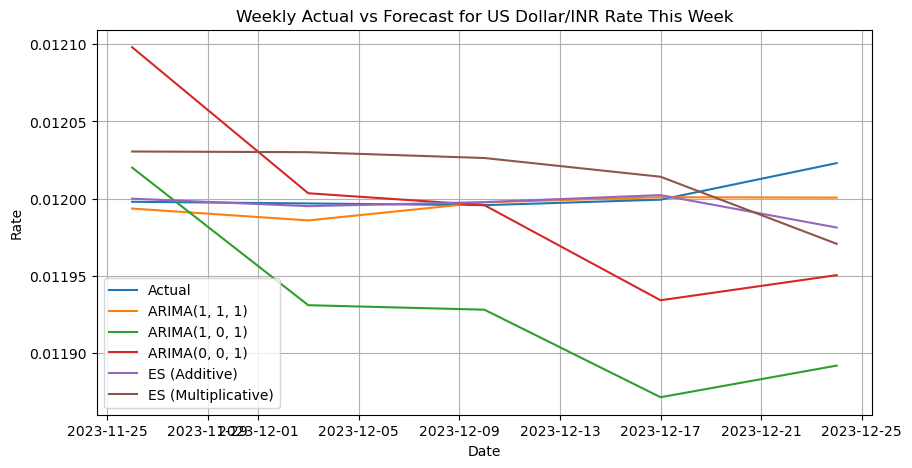

ARIMA(1, 1, 1) RMSE: 1.1376946299154395e-05
ARIMA(1, 0, 1) RMSE: 9.284143656876553e-05
ARIMA(0, 0, 1) RMSE: 6.264587335450686e-05
ES (Additive) RMSE: 1.8785467375891848e-05
ES (Multiplicative) RMSE: 3.48287107539087e-05


/var/folders/ts/sqvxkby101b3x__cvt7j6vdr0000gn/T/ipykernel_2898/4076844438.py:78: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/ba

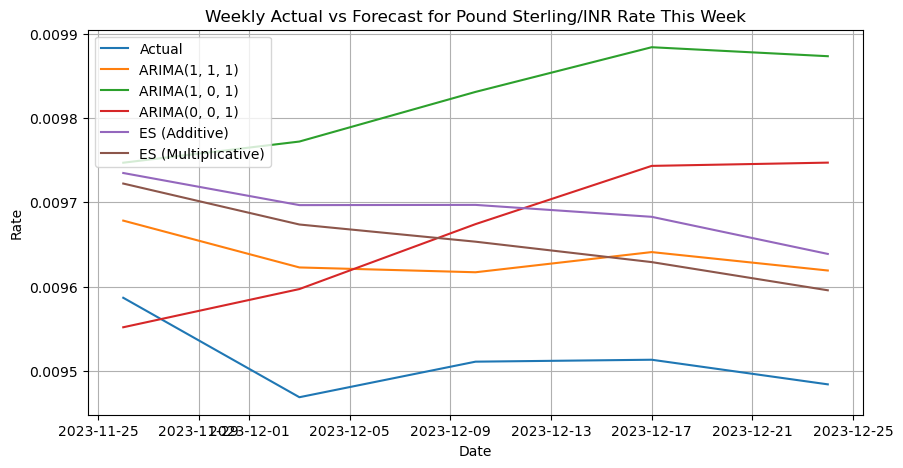

ARIMA(1, 1, 1) RMSE: 0.0001250043365078646
ARIMA(1, 0, 1) RMSE: 0.00031960026654105807
ARIMA(0, 0, 1) RMSE: 0.0001827125923870605
ES (Additive) RMSE: 0.00017979762024290355
ES (Multiplicative) RMSE: 0.0001461605341270666


/var/folders/ts/sqvxkby101b3x__cvt7j6vdr0000gn/T/ipykernel_2898/4076844438.py:78: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/st

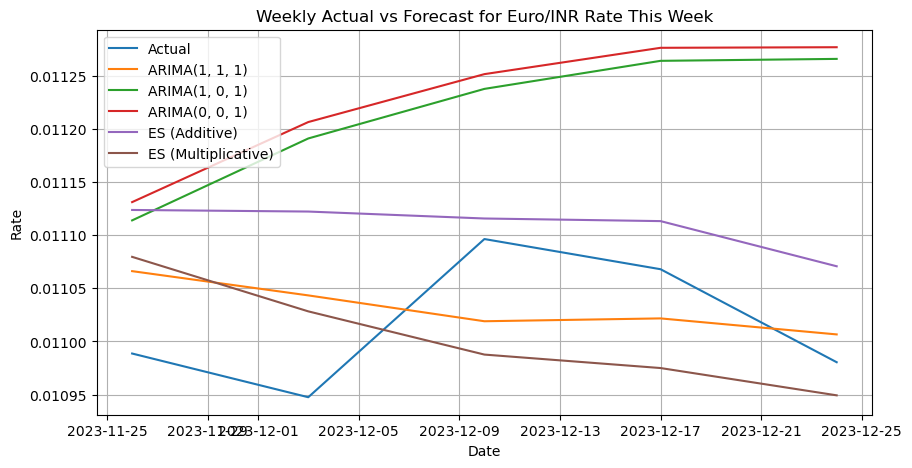

ARIMA(1, 1, 1) RMSE: 6.927648548206493e-05
ARIMA(1, 0, 1) RMSE: 0.00020728327229133165
ARIMA(0, 0, 1) RMSE: 0.00022029725466925438
ES (Additive) RMSE: 0.00010893983477794518
ES (Multiplicative) RMSE: 8.512841497006635e-05


/var/folders/ts/sqvxkby101b3x__cvt7j6vdr0000gn/T/ipykernel_2898/4076844438.py:78: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/st

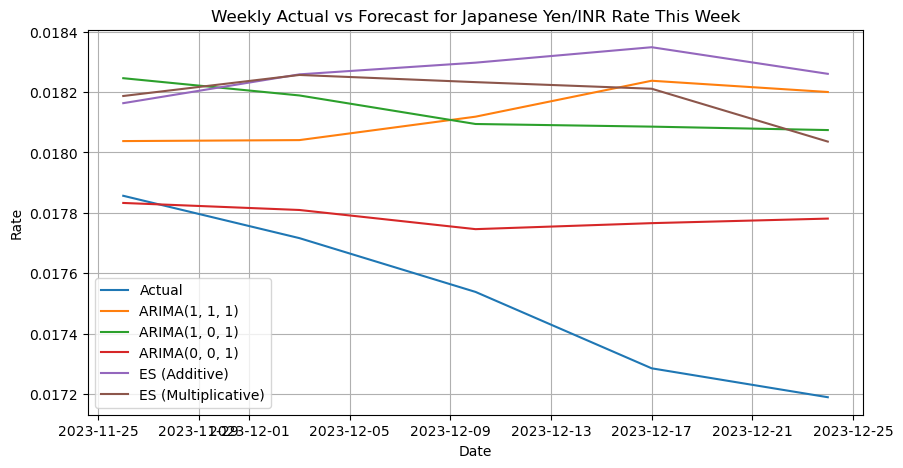

ARIMA(1, 1, 1) RMSE: 0.0006929328107857429
ARIMA(1, 0, 1) RMSE: 0.0006488444507915586
ARIMA(0, 0, 1) RMSE: 0.0003557412535278606
ES (Additive) RMSE: 0.0008047921484248815
ES (Multiplicative) RMSE: 0.0007006873770634647
+----+-----------------------------------+-----------------+---------------+-----------------+-------------------------+-------------------------+--------------------------+------------------+----------------+------------------+---------------------------+--------------------------+----------------------------+--------------------------+
|    | Column                            |   ADF Statistic |   ADF p-value | ADF Unit Root   |   ADF Critical Value 1% |   ADF Critical Value 5% |   ADF Critical Value 10% |   KPSS Statistic |   KPSS p-value | KPSS Unit Root   |   KPSS Critical Value 10% |   KPSS Critical Value 5% |   KPSS Critical Value 2.5% |   KPSS Critical Value 1% |
+====+===================================+=================+===============+=================+=======

/var/folders/ts/sqvxkby101b3x__cvt7j6vdr0000gn/T/ipykernel_2898/4076844438.py:78: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error
from tabulate import tabulate
from datetime import datetime

def load_data(file_path):
    data = pd.read_excel(file_path)
    data['Date This Week'] = pd.to_datetime(data['Date This Week'])
    data.set_index('Date This Week', inplace=True)
    return data

def prepare_data(data, forecast_period=30):
    data.fillna(method='ffill', inplace=True)  # First forward fill
    data.fillna(method='bfill', inplace=True)  # Then backward fill if needed
    cutoff_date = data.index.max() - pd.DateOffset(months=1)
    train = data[data.index <= cutoff_date]
    test = data[data.index > cutoff_date]
    return train, test

def forecast_currency(train, test, rate_column):
    # Explicit check and handle NaN before fitting the model
    if train[rate_column].isna().any():
        train[rate_column].fillna(train[rate_column].mean(), inplace=True)  # Using mean to fill any stubborn NaNs
    if test[rate_column].isna().any():
        test[rate_column].fillna(train[rate_column].mean(), inplace=True)

    forecasts = {}

    # ARIMA models
    try:
        arima_orders = [(1, 1, 1), (1, 0, 1), (0, 0, 1)]
        for order in arima_orders:
            model = SARIMAX(train[rate_column], order=order, seasonal_order=(1, 1, 1, 12)).fit(disp=False)
            forecasts[f'ARIMA{order}'] = model.forecast(len(test))
    except Exception as e:
        print(f"ARIMA model fitting failed for {rate_column}: {e}")
        for order in arima_orders:
            forecasts[f'ARIMA{order}'] = np.full(len(test), np.nan)

    # Exponential Smoothing models
    try:
        es_model_add = ExponentialSmoothing(train[rate_column], trend='add', seasonal='add', seasonal_periods=12).fit()
        es_model_mul = ExponentialSmoothing(train[rate_column], trend='mul', seasonal='mul', seasonal_periods=12).fit()
        forecasts['ES (Additive)'] = es_model_add.forecast(len(test))
        forecasts['ES (Multiplicative)'] = es_model_mul.forecast(len(test))
    except Exception as e:
        print(f"Exponential Smoothing model fitting failed for {rate_column}: {e}")
        forecasts['ES (Additive)'] = np.full(len(test), np.nan)
        forecasts['ES (Multiplicative)'] = np.full(len(test), np.nan)

    return forecasts, test[rate_column]

def calculate_rmse(actual, forecast):
    return np.sqrt(mean_squared_error(actual, forecast))

def display_results(test, actual, forecasts, currency_name):
    plt.figure(figsize=(10, 5))
    plt.plot(test.index, actual, label='Actual')
    for name, forecast in forecasts.items():
        plt.plot(test.index, forecast, label=name)
    plt.title(f'Weekly Actual vs Forecast for {currency_name}')
    plt.xlabel('Date')
    plt.ylabel('Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    for name, forecast in forecasts.items():
        print(f"{name} RMSE: {calculate_rmse(actual, forecast)}")

def unit_root_test(series, column_name):
    adf_result = adfuller(series)
    kpss_result = kpss(series, regression='c', nlags="auto")

    adf_unit_root = 'No' if adf_result[1] < 0.05 else 'Yes'
    kpss_unit_root = 'No' if kpss_result[1] < 0.05 else 'Yes'

    return {
        'Column': column_name,
        'ADF Statistic': adf_result[0],
        'ADF p-value': adf_result[1],
        'ADF Unit Root': adf_unit_root,
        'ADF Critical Value 1%': adf_result[4]['1%'],
        'ADF Critical Value 5%': adf_result[4]['5%'],
        'ADF Critical Value 10%': adf_result[4]['10%'],
        'KPSS Statistic': kpss_result[0],
        'KPSS p-value': kpss_result[1],
        'KPSS Unit Root': kpss_unit_root,
        'KPSS Critical Value 10%': kpss_result[3]['10%'],
        'KPSS Critical Value 5%': kpss_result[3]['5%'],
        'KPSS Critical Value 2.5%': kpss_result[3]['2.5%'],
        'KPSS Critical Value 1%': kpss_result[3]['1%']
    }

def main():
    today_date = datetime.now().strftime('%Y%m%d')
    file_path = f'/Users/akshay/Downloads/2_way_arbitrage_opportunities_weekly_{today_date}.xlsx'
    data = load_data(file_path)
    train, test = prepare_data(data)
    currencies = ['US Dollar', 'Pound Sterling', 'Euro', 'Japanese Yen']
    all_results = []

    for currency in currencies:
        rate_column = f'{currency}/INR Rate This Week'
        forecasts, actual = forecast_currency(train, test, rate_column)
        display_results(test, actual, forecasts, rate_column)

        # Perform unit root test
        unit_root_results = unit_root_test(train[rate_column], rate_column)
        all_results.append(unit_root_results)

    # Create DataFrame for results
    results_df = pd.DataFrame(all_results)

    # Save the DataFrame to an Excel file
    results_df.to_excel(f'/Users/akshay/Downloads/2_way_weekly_unit_root_test_results{today_date}.xlsx', index=False)

    # Print results with tabulate
    print(tabulate(results_df, headers='keys', tablefmt='grid'))

if __name__ == "__main__":
    main()


In [35]:
def load_and_prepare_data(file_path):
     # Load the weekly dataset
    data = pd.read_excel(file_path)
    
    # Convert 'Date' column to datetime if it's not already
    data['Date'] = pd.to_datetime(data['Date'])
    

    rate_columns = ['US Dollar', 'Pound Sterling', 'Euro', 'Japanese Yen']
    for col in rate_columns:
        # Convert rates from INR to each currency
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[f'{col}/INR'] = 1 / data[col]  # Inverse for INR to Currency

    data = data.sort_values(by='Date')
    return data

def find_3_way_arbitrage(data, initial_inr=100):
    currencies = ['US Dollar', 'Pound Sterling', 'Euro', 'Japanese Yen']
    currency_pairs = list(permutations(currencies, 3))
    opportunities = []

    for i in range(len(data) - 1):
        row_this_week = data.iloc[i]
        row_next_week = data.iloc[i + 1]

        for pair in currency_pairs:
            rate1_this_week = row_this_week[f'{pair[0]}/INR']
            rate2_this_week = row_this_week[f'{pair[1]}/INR']
            rate3_this_week = row_this_week[f'{pair[2]}/INR']

            rate2_next_week = row_next_week[f'{pair[1]}/INR']
            rate3_next_week = row_next_week[f'{pair[2]}/INR']

          # Calculate cross rates for intra-week
            cross_rate1_2_this_week = rate2_this_week / rate1_this_week
            cross_rate2_3_this_week = rate3_this_week / rate2_this_week
            cross_rate3_1_this_week = rate1_this_week / rate3_this_week

            # Calculate cross rates for inter-week
            cross_rate2_3_next_week = rate3_next_week / rate2_next_week
            cross_rate3_1_next_week = rate1_this_week / rate3_next_week

            # Calculate final amounts for intra-week and inter-week
            final_amount_this_week = initial_inr * cross_rate1_2_this_week * cross_rate2_3_this_week * cross_rate3_1_this_week
            final_amount_next_week = initial_inr * cross_rate1_2_this_week * cross_rate2_3_next_week * cross_rate3_1_next_week

            profit_this_week = final_amount_this_week - initial_inr
            profit_percentage_this_week = (profit_this_week / initial_inr) * 100

            profit_next_week = final_amount_next_week - initial_inr
            profit_percentage_next_week = (profit_next_week / initial_inr) * 100


            if profit_this_week > 0:
                print(f"3-way Arbitrage for {pair[0]} -> {pair[1]} -> {pair[2]} at {row_this_week['Date']} is {profit_this_week}")
                opportunities.append({
                    'Date': row_this_week['Date'],
                    'Currencies': f"{pair[0]} -> {pair[1]} -> {pair[2]}",
                    'Profit': profit_this_week,
                    'Profit Percentage': profit_percentage_this_week,
                    'Type': 'Intra-week'
                })

            if profit_next_week > 0:
                print(f"3-way Arbitrage for {pair[0]} -> {pair[1]} -> {pair[2]} at {row_next_week['Date']} is {profit_next_week}")
                opportunities.append({
                    'Date': row_next_week['Date'],
                    'Currencies': f"{pair[0]} -> {pair[1]} -> {pair[2]}",
                    'Profit': profit_next_week,
                    'Profit Percentage': profit_percentage_next_week,
                    'Type': 'Inter-week'
                })

    return pd.DataFrame(opportunities)

# Assuming data loading and function calls are handled as before
file_path = '/Users/akshay/Downloads/weekly_exchange_rates.xlsx'
prepared_data = load_and_prepare_data(file_path)
if not prepared_data.empty:
    arbitrage_opportunities_df = find_3_way_arbitrage(prepared_data)
    if not arbitrage_opportunities_df.empty:
        # Get today's date and format it as YYYYMMDD
        today_date = datetime.now().strftime('%Y%m%d')
        # Create the output file name with today's date
        output_file_path = f'/Users/akshay/Downloads/3_way_arbitrage_opportunities_weekly_{today_date}.xlsx'
        arbitrage_opportunities_df.to_excel(output_file_path, index=False)
        print(f"Arbitrage opportunities saved to Excel at {output_file_path}.")
    else:
        print("No significant arbitrage opportunities found.")
else:
    print("Data loading or preparation failed.")


3-way Arbitrage for Euro -> Pound Sterling -> Japanese Yen at 2010-01-03 00:00:00 is 2.842170943040401e-14
3-way Arbitrage for Japanese Yen -> Euro -> Pound Sterling at 2010-01-03 00:00:00 is 1.4210854715202004e-14
3-way Arbitrage for Pound Sterling -> US Dollar -> Japanese Yen at 2010-01-10 00:00:00 is 1.4210854715202004e-14
3-way Arbitrage for US Dollar -> Pound Sterling -> Euro at 2010-01-24 00:00:00 is 1.384182798154356
3-way Arbitrage for US Dollar -> Pound Sterling -> Japanese Yen at 2010-01-17 00:00:00 is 1.4210854715202004e-14
3-way Arbitrage for US Dollar -> Pound Sterling -> Japanese Yen at 2010-01-24 00:00:00 is 1.3841827981543418
3-way Arbitrage for US Dollar -> Euro -> Pound Sterling at 2010-01-17 00:00:00 is 1.4210854715202004e-14
3-way Arbitrage for US Dollar -> Japanese Yen -> Pound Sterling at 2010-01-17 00:00:00 is 1.4210854715202004e-14
3-way Arbitrage for US Dollar -> Japanese Yen -> Pound Sterling at 2010-01-24 00:00:00 is 1.6712979743062988
3-way Arbitrage for US 

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is avai

RMSE for Intra-week:
ARIMA(1, 1, 1): 2.213558591732404e-15
ARIMA(1, 0, 1): 2.4349505318287107e-15
ARIMA(0, 0, 1): 2.411289745551313e-15
ES (Additive): 1.0256445046035615e-15
ES (Multiplicative): 1.0807146059340923e-15

RMSE for Inter-week:
ARIMA(1, 1, 1): 0.5535519019628363
ARIMA(1, 0, 1): 0.4343122680694001
ARIMA(0, 0, 1): 0.4355028611509999
ES (Additive): 0.5922046932771344
ES (Multiplicative): 1.2016730328674956


/var/folders/ts/sqvxkby101b3x__cvt7j6vdr0000gn/T/ipykernel_2898/3502878374.py:84: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")


+----+-----------------------+-----------------+---------------+-----------------+-------------------------+-------------------------+--------------------------+------------------+----------------+------------------+---------------------------+--------------------------+----------------------------+--------------------------+
|    | Column                |   ADF Statistic |   ADF p-value | ADF Unit Root   |   ADF Critical Value 1% |   ADF Critical Value 5% |   ADF Critical Value 10% |   KPSS Statistic |   KPSS p-value | KPSS Unit Root   |   KPSS Critical Value 10% |   KPSS Critical Value 5% |   KPSS Critical Value 2.5% |   KPSS Critical Value 1% |
+====+=======================+=================+===============+=================+=========================+=========================+==========================+==================+================+==================+===========================+==========================+============================+==========================+
|  0 | Intra-wee

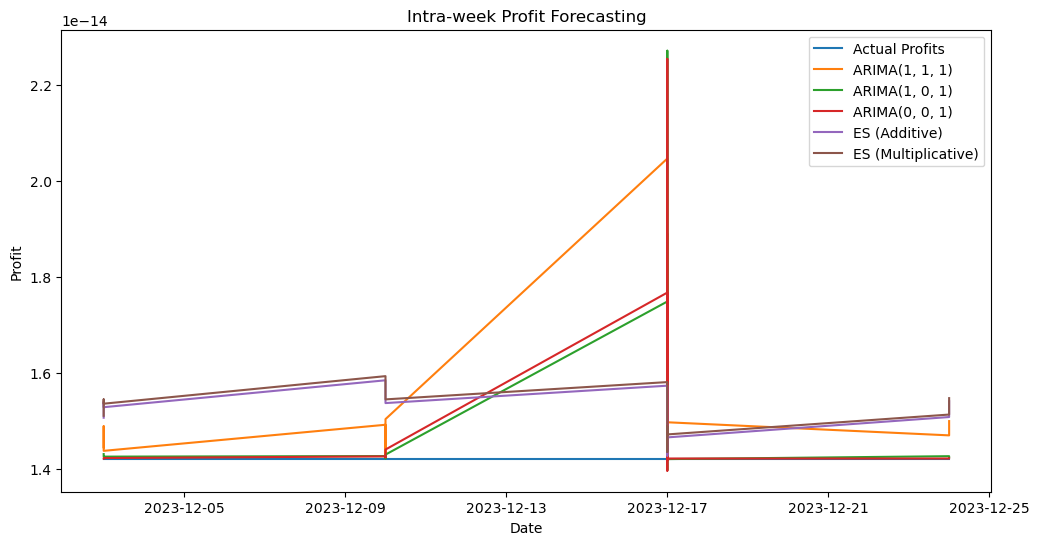

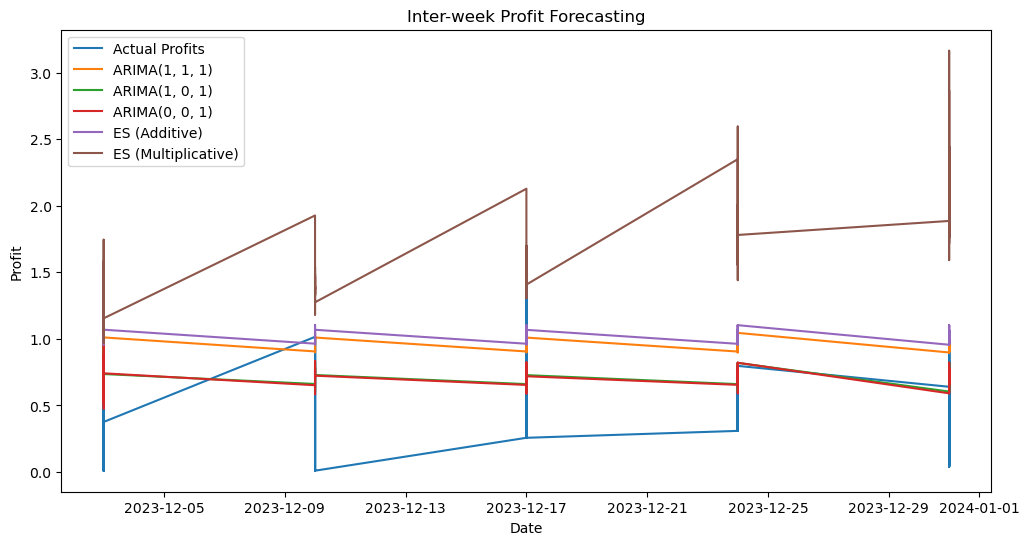

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error
from datetime import datetime
from tabulate import tabulate

# Load data
today_date = datetime.now().strftime('%Y%m%d')
file_path = f'/Users/akshay/Downloads/3_way_arbitrage_opportunities_weekly_{today_date}.xlsx'
data = pd.read_excel(file_path)
data['Date'] = pd.to_datetime(data['Date'])  # Ensure 'Date' is a datetime type

# Split data by type
intra_week_data = data[data['Type'] == 'Intra-week']
inter_week_data = data[data['Type'] == 'Inter-week']

# Function to split data into train and test
def split_data(df):
    last_month = df['Date'].max().replace(day=1)  # Find the first day of the last month in the data
    train = df[df['Date'] < last_month]
    test = df[df['Date'] >= last_month]
    return train, test

# Splitting both intra-week and inter-week data
train_intra, test_intra = split_data(intra_week_data)
train_inter, test_inter = split_data(inter_week_data)

# Forecasting model function
def forecast_model(train, test, column):
    forecasts = {}

    # ARIMA models
    try:
        arima_orders = [(1, 1, 1), (1, 0, 1), (0, 0, 1)]
        for order in arima_orders:
            model = SARIMAX(train[column], order=order, seasonal_order=(1, 1, 1, 12)).fit(disp=False)
            forecasts[f'ARIMA{order}'] = model.forecast(len(test))
    except Exception as e:
        print(f"ARIMA model fitting failed for {column}: {e}")
        for order in arima_orders:
            forecasts[f'ARIMA{order}'] = np.full(len(test), np.nan)

    # Exponential Smoothing models
    try:
        es_model_add = ExponentialSmoothing(train[column], trend='add', seasonal='add', seasonal_periods=12).fit()
        es_model_mul = ExponentialSmoothing(train[column], trend='mul', seasonal='mul', seasonal_periods=12).fit()
        forecasts['ES (Additive)'] = es_model_add.forecast(len(test))
        forecasts['ES (Multiplicative)'] = es_model_mul.forecast(len(test))
    except Exception as e:
        print(f"Exponential Smoothing model fitting failed for {column}: {e}")
        forecasts['ES (Additive)'] = np.full(len(test), np.nan)
        forecasts['ES (Multiplicative)'] = np.full(len(test), np.nan)

    return forecasts, test[column].values

# Example usage on intra-week and inter-week data for 'Profit'
forecasts_intra, actual_intra = forecast_model(train_intra, test_intra, 'Profit')
forecasts_inter, actual_inter = forecast_model(train_inter, test_inter, 'Profit')

# Function to calculate RMSE
def calculate_rmse(actual, forecast):
    return np.sqrt(mean_squared_error(actual, forecast))

# Calculate RMSE for both intra-week and inter-week
rmse_results_intra = {name: calculate_rmse(actual_intra, forecast) for name, forecast in forecasts_intra.items()}
rmse_results_inter = {name: calculate_rmse(actual_inter, forecast) for name, forecast in forecasts_inter.items()}

# Output RMSE results
print("RMSE for Intra-week:")
for name, rmse in rmse_results_intra.items():
    print(f"{name}: {rmse}")

print("\nRMSE for Inter-week:")
for name, rmse in rmse_results_inter.items():
    print(f"{name}: {rmse}")

# Function to perform ADF and KPSS tests
def unit_root_test(series, column_name):
    adf_result = adfuller(series)
    kpss_result = kpss(series, regression='c', nlags="auto")

    adf_unit_root = 'No' if adf_result[1] < 0.05 else 'Yes'
    kpss_unit_root = 'No' if kpss_result[1] < 0.05 else 'Yes'

    return {
        'Column': column_name,
        'ADF Statistic': adf_result[0],
        'ADF p-value': adf_result[1],
        'ADF Unit Root': adf_unit_root,
        'ADF Critical Value 1%': adf_result[4]['1%'],
        'ADF Critical Value 5%': adf_result[4]['5%'],
        'ADF Critical Value 10%': adf_result[4]['10%'],
        'KPSS Statistic': kpss_result[0],
        'KPSS p-value': kpss_result[1],
        'KPSS Unit Root': kpss_unit_root,
        'KPSS Critical Value 10%': kpss_result[3]['10%'],
        'KPSS Critical Value 5%': kpss_result[3]['5%'],
        'KPSS Critical Value 2.5%': kpss_result[3]['2.5%'],
        'KPSS Critical Value 1%': kpss_result[3]['1%']
    }

# Perform unit root tests on training data
unit_root_results_intra = unit_root_test(train_intra['Profit'], 'Intra-week Train Data')
unit_root_results_inter = unit_root_test(train_inter['Profit'], 'Inter-week Train Data')

# Create DataFrame for unit root test results
unit_root_df = pd.DataFrame([unit_root_results_intra, unit_root_results_inter])

# Save the DataFrame to an Excel file
unit_root_df.to_excel(f'/Users/akshay/Downloads/unit_root_test_results_3_way_weekly_{today_date}.xlsx', index=False)

# Print unit root test results with tabulate
print(tabulate(unit_root_df, headers='keys', tablefmt='grid'))

# Plotting the results for intra-week
plt.figure(figsize=(12, 6))
plt.plot(test_intra['Date'], actual_intra, label='Actual Profits')
for name, forecast in forecasts_intra.items():
    plt.plot(test_intra['Date'], forecast, label=name)
plt.title('Intra-week Profit Forecasting')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.show()

# Plotting the results for inter-week
plt.figure(figsize=(12, 6))
plt.plot(test_inter['Date'], actual_inter, label='Actual Profits')
for name, forecast in forecasts_inter.items():
    plt.plot(test_inter['Date'], forecast, label=name)
plt.title('Inter-week Profit Forecasting')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-97524.810, Time=0.57 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=4.66 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-101921.801, Time=3.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-97123.672, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-97862.345, Time=0.68 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.96 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-99108.720, Time=3.28 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-101755.776, Time=2.15 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-99109.095, Time=4.86 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=-102713.272, Time=3.83 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=-101955.044, Time=0.83 sec
 ARIMA(0,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.53 sec
 ARIMA(0,0,2)(1,0,0)[12] intercept   : AIC=-101389.641, Time=2.78 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-97330.516, Time=4.04 sec
 ARIMA(

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/stats

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=15500.529, Time=0.34 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=15465.248, Time=2.00 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=15470.368, Time=1.46 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=15498.529, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=15502.529, Time=0.24 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=15410.951, Time=3.59 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=15470.368, Time=2.77 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=15408.951, Time=3.93 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=15468.368, Time=2.19 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=15463.248, Time=1.47 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=15410.951, Time=4.11 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=26.93 sec
 ARIMA(0,1,0)(1,0,1)[12]             : AIC=15406.951, Time=1.26 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=15466.368, Time=0.52 sec
 ARIMA(0,1

/opt/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(1,1,1)(1,0,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/opt/anaconda3/lib/python3.11/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py", line 704, in fit
    mlef

 ARIMA(1,1,1)(1,0,1)[12]             : AIC=inf, Time=nan sec

Best model:  ARIMA(0,1,0)(1,0,1)[12]          
Total fit time: 69.595 seconds
RMSE for ARIMA (Intra-week): 3.4769710646270343e-06
RMSE for ES (Intra-week): 1.0256445046035615e-15
RMSE for ARIMA (Inter-week): 0.6372222137743941
RMSE for ES (Inter-week): 0.5922046932771344


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


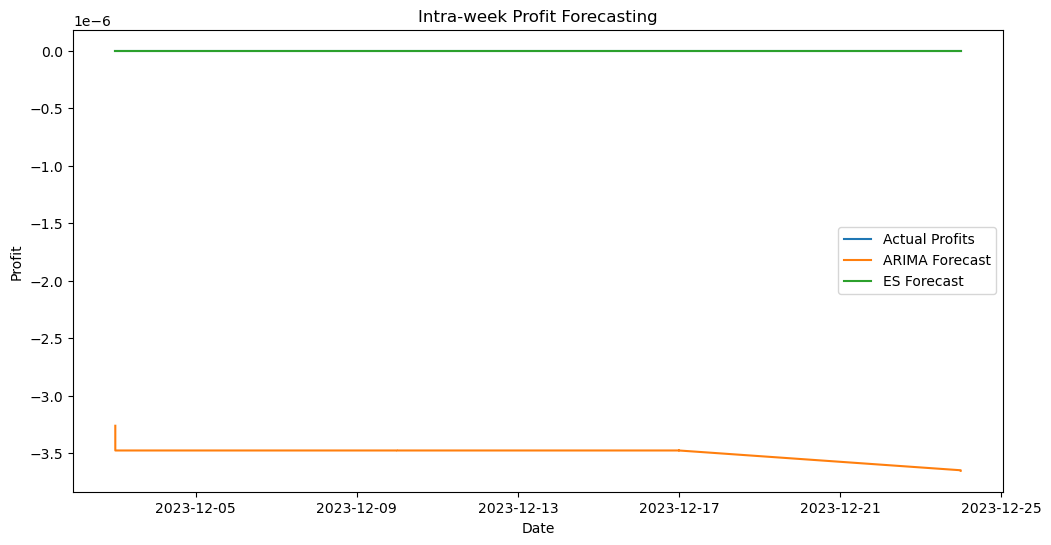

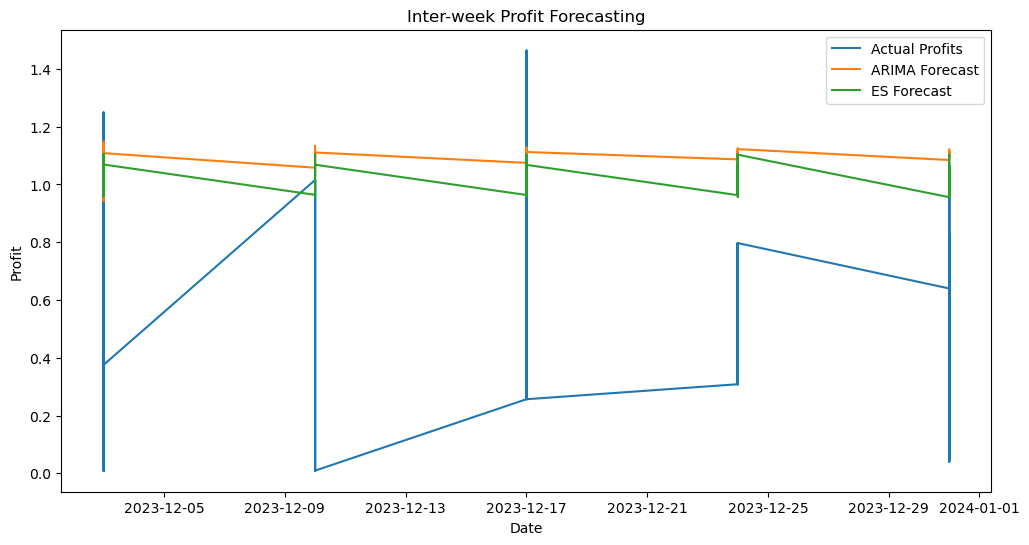

In [14]:
# Load data
today_date = datetime.now().strftime('%Y%m%d')
file_path = f'/Users/akshay/Downloads/3_way_arbitrage_opportunities_weekly_{today_date}.xlsx'
data = pd.read_excel(file_path)
data['Date'] = pd.to_datetime(data['Date'])  # Ensure 'Date' is a datetime type

# Split data by type
intra_week_data = data[data['Type'] == 'Intra-week']
inter_week_data = data[data['Type'] == 'Inter-week']

# Function to split data into train and test
def split_data(df):
    last_month = df['Date'].max().replace(day=1)  # Find the first day of the last month in the data
    train = df[df['Date'] < last_month]
    test = df[df['Date'] >= last_month]
    return train, test

# Splitting both intra-week and inter-week data
train_intra, test_intra = split_data(intra_week_data)
train_inter, test_inter = split_data(inter_week_data)

# Forecasting model function
def forecast_model(train, test, column):
    # ARIMA Model optimized for quicker computation
    arima_model = auto_arima(train[column], seasonal=True, m=12, stepwise=True, suppress_warnings=True,
                             start_p=0, max_p=2, start_q=0, max_q=2,
                             start_P=0, max_P=1, start_D=0, max_D=1, start_Q=0, max_Q=1,
                             trace=True, n_jobs=-1)
    arima_forecast = arima_model.predict(n_periods=len(test))

    # Exponential Smoothing
    es_model = ExponentialSmoothing(train[column], trend='add', seasonal='add', seasonal_periods=12).fit()
    es_forecast = es_model.forecast(len(test))

    return arima_forecast, es_forecast, test[column].values

# Example usage on intra-week and inter-week data for 'Profit'
arima_forecast_intra, es_forecast_intra, actual_intra = forecast_model(train_intra, test_intra, 'Profit')
arima_forecast_inter, es_forecast_inter, actual_inter = forecast_model(train_inter, test_inter, 'Profit')

# Function to calculate RMSE
def calculate_rmse(actual, forecast):
    return np.sqrt(mean_squared_error(actual, forecast))

# Calculate RMSE for both intra-week and inter-week
rmse_arima_intra = calculate_rmse(actual_intra, arima_forecast_intra)
rmse_es_intra = calculate_rmse(actual_intra, es_forecast_intra)
rmse_arima_inter = calculate_rmse(actual_inter, arima_forecast_inter)
rmse_es_inter = calculate_rmse(actual_inter, es_forecast_inter)

# Output RMSE results
print(f"RMSE for ARIMA (Intra-week): {rmse_arima_intra}")
print(f"RMSE for ES (Intra-week): {rmse_es_intra}")
print(f"RMSE for ARIMA (Inter-week): {rmse_arima_inter}")
print(f"RMSE for ES (Inter-week): {rmse_es_inter}")

# Plotting the results for intra-week
plt.figure(figsize=(12, 6))
plt.plot(test_intra['Date'], actual_intra, label='Actual Profits')
plt.plot(test_intra['Date'], arima_forecast_intra, label='ARIMA Forecast')
plt.plot(test_intra['Date'], es_forecast_intra, label='ES Forecast')
plt.title('Intra-week Profit Forecasting')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.show()

# Plotting the results for inter-week
plt.figure(figsize=(12, 6))
plt.plot(test_inter['Date'], actual_inter, label='Actual Profits')
plt.plot(test_inter['Date'], arima_forecast_inter, label='ARIMA Forecast')
plt.plot(test_inter['Date'], es_forecast_inter, label='ES Forecast')
plt.title('Inter-week Profit Forecasting')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.1

RMSE for ARIMA (Intra-week): 2.213558591732404e-15
RMSE for ES (Intra-week): 1.0256445046035615e-15
RMSE for ARIMA (Inter-week): 0.5535519019628363
RMSE for ES (Inter-week): 0.5922046932771344


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


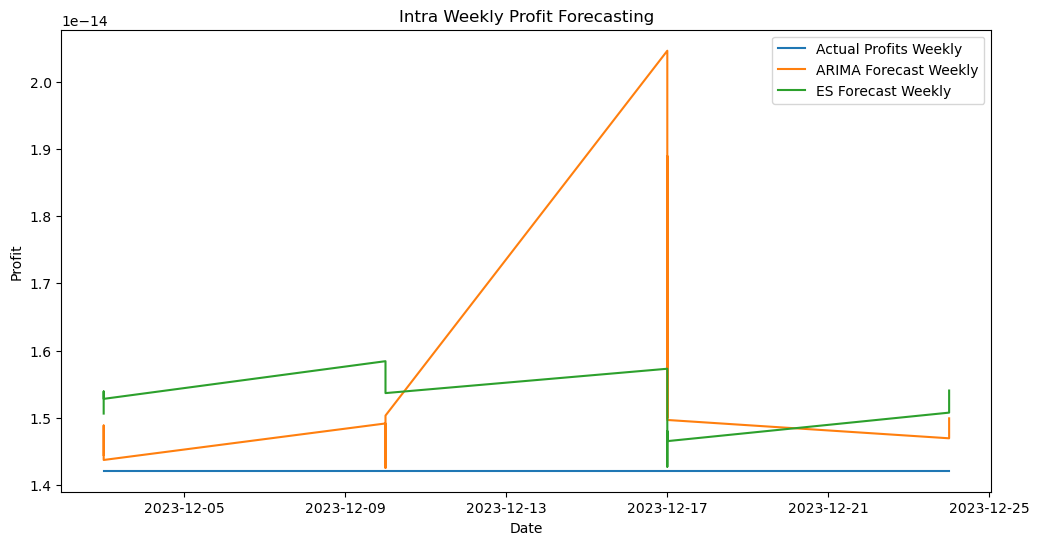

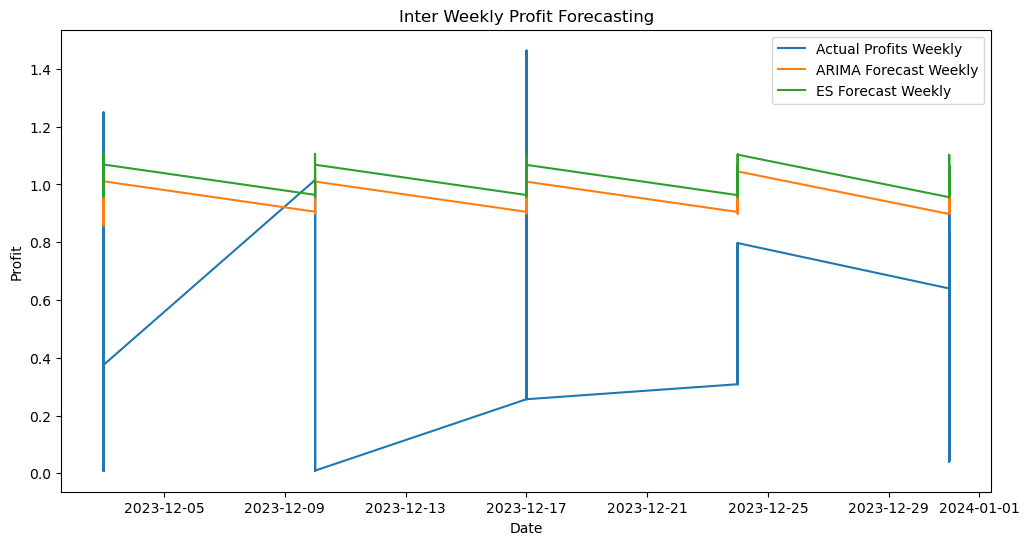

In [17]:
# Load the data
today_date = datetime.now().strftime('%Y%m%d')
file_path = f'/Users/akshay/Downloads/3_way_arbitrage_opportunities_weekly_{today_date}.xlsx'

data = pd.read_excel(file_path)
data['Date'] = pd.to_datetime(data['Date'])  # Convert Date to datetime type
data.set_index('Date', inplace=True)  # Set Date as the index

# Split data by type
intra_day_week = data[data['Type'] == 'Intra-week']
inter_day_week = data[data['Type'] == 'Inter-week']

# Function to split data into train and test sets
def split_data(df):
    last_month = df.index.max().replace(day=1)  # Identify the first day of the last month
    train = df[df.index < last_month]
    test = df[df.index >= last_month]
    return train, test

# Splitting intra-week and inter-day week
train_intra, test_intra = split_data(intra_day_week)
train_inter, test_inter = split_data(inter_day_week)

# Function to apply ARIMA and Exponential Smoothing
def forecast_model(train, test, column='Profit'):
    # Fit ARIMA model with default parameters
    arima_model = SARIMAX(train[column], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(disp=0)
    arima_forecast = arima_model.get_forecast(steps=len(test)).predicted_mean

    # Fit Exponential Smoothing model
    es_model = ExponentialSmoothing(train[column], trend='add', seasonal='add', seasonal_periods=12).fit()
    es_forecast = es_model.forecast(len(test))

    return arima_forecast, es_forecast, test[column]  # Return forecasts and actuals

# Forecasting on intra-day and inter-day data
arima_forecast_intra, es_forecast_intra, actual_intra = forecast_model(train_intra,test_intra)
arima_forecast_inter, es_forecast_inter, actual_inter = forecast_model(train_inter,test_inter)

# Function to calculate RMSE
def calculate_rmse(actual, forecast):
    return np.sqrt(mean_squared_error(actual, forecast))

# Calculate RMSE for both intra-week and inter-week
rmse_arima_intra = calculate_rmse(actual_intra, arima_forecast_intra)
rmse_es_intra = calculate_rmse(actual_intra, es_forecast_intra)
rmse_arima_inter = calculate_rmse(actual_inter, arima_forecast_inter)
rmse_es_inter = calculate_rmse(actual_inter, es_forecast_inter)

# Output RMSE results
print(f"RMSE for ARIMA (Intra-week): {rmse_arima_intra}")
print(f"RMSE for ES (Intra-week): {rmse_es_intra}")
print(f"RMSE for ARIMA (Inter-week): {rmse_arima_inter}")
print(f"RMSE for ES (Inter-week): {rmse_es_inter}")

# Plotting the results for intra-week
plt.figure(figsize=(12, 6))
plt.plot(test_intra.index, actual_intra, label='Actual Profits Weekly')
plt.plot(test_intra.index, arima_forecast_intra, label='ARIMA Forecast Weekly')
plt.plot(test_intra.index, es_forecast_intra, label='ES Forecast Weekly')
plt.title('Intra Weekly Profit Forecasting')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.show()

# Plotting the results for inter week
plt.figure(figsize=(12, 6))
plt.plot(test_inter.index, actual_inter, label='Actual Profits Weekly')
plt.plot(test_inter.index, arima_forecast_inter, label='ARIMA Forecast Weekly')
plt.plot(test_inter.index, es_forecast_inter, label='ES Forecast Weekly')
plt.title('Inter Weekly Profit Forecasting')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.show()
